# TRAIN MODELS & CROSS-VALIDATION

## Import libraries:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt  
from matplotlib.ticker import PercentFormatter
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from matplotlib.colors import ListedColormap
from Bio import SeqIO
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import itertools

import sys
sys.path.append('./ML/')
from seq_utils import *
from ML_utils import *
import torch

import xgboost as xgb
#from antiberty import AntiBERTyRunner

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.multiclass import OneVsRestClassifier


## Load data:

In [2]:
# --- Read csv file:
Data = pd.read_csv('./Data/Datasets/Boughter_Jain_Shehata_data.csv',index_col=[0])

Data[:5]

,Ab type,Dataset,L-CDR1,L-CDR2,L-CDR3,H-CDR1,H-CDR2,H-CDR3,VH,VL,VH_VL_joined,HL-CDRs_joined,H-CDRs_joined,L-CDRs_joined,react,PSR Score
Name,,,,,,,,,,,,,,,,
0,Mouse IgA,Boughter,TDIDDD,EGN,LQSDNMPYTF,GYSITSDY,ISYSGST,ARRGYYYGSFDYW,QVQLKQSGPGLAKPSQTLSLTCSVTGYSITSDYWNWIRKFPGNKLE...,DIQMTQSPASLSVATGEKVTIRCITSTDIDDDMNWYQQKPGEPPKL...,QVQLKQSGPGLAKPSQTLSLTCSVTGYSITSDYWNWIRKFPGNKLE...,GYSITSDYISYSGSTARRGYYYGSFDYWTDIDDDEGNLQSDNMPYTF,GYSITSDYISYSGSTARRGYYYGSFDYW,TDIDDDEGNLQSDNMPYTF,0,NaN
1,Mouse IgA,Boughter,QEISGY,AAS,LQYASYPPTF,GYTFTSYW,IHPSDSDT,AIDYDQAMDYW,HSQLQESGAELVKPGASVKVSCKASGYTFTSYWMHWVKQRPGQGLE...,DIQMNQSPSSLSASLGERVSLTCRASQEISGYLSWLQQKPDGTIKR...,HSQLQESGAELVKPGASVKVSCKASGYTFTSYWMHWVKQRPGQGLE...,GYTFTSYWIHPSDSDTAIDYDQAMDYWQEISGYAASLQYASYPPTF,GYTFTSYWIHPSDSDTAIDYDQAMDYW,QEISGYAASLQYASYPPTF,0,NaN
2,Mouse IgA,Boughter,QDVGTA,WAS,QQYSSYPFTF,GYSITSGYY,ISYDGS,ARFYGNYEDYYAMDYW,QVQLKQSGPGLVKPSQSLSLTCSVTGYSITSGYYWNWIRQFPGNKL...,ETTVTQSHKFMSTSVGDRVSITCKASQDVGTAVAWYQQKPGQSPKL...,QVQLKQSGPGLVKPSQSLSLTCSVTGYSITSGYYWNWIRQFPGNKL...,GYSITSGYYISYDGSARFYGNYEDYYAMDYWQDVGTAWASQQYSSY...,GYSITSGYYISYDGSARFYGNYEDYYAMDYW,QDVGTAWASQQYSSYPFTF,0,NaN
3,Mouse IgA,Boughter,QDIGSS,AT,LQYASSPWTF,GFTFTDYY,IRNKANGYTT,ARLDSSGYDYAMDYW,EVQLLETGGGLVQPGGSLSLSCAASGFTFTDYYMSWVRQPPGKALE...,DIQMNQSPSSLSASLGERVSLTCRASQDIGSSLNWLQQEPDGTIKR...,EVQLLETGGGLVQPGGSLSLSCAASGFTFTDYYMSWVRQPPGKALE...,GFTFTDYYIRNKANGYTTARLDSSGYDYAMDYWQDIGSSATLQYAS...,GFTFTDYYIRNKANGYTTARLDSSGYDYAMDYW,QDIGSSATLQYASSPWTF,0,NaN
4,Mouse IgA,Boughter,QSIGTS,YAS,QQSNSWPLTF,GFTFSSYG,ISSGGSYT,ARQEGNSGEYYFDYW,EVKLEESGGDLVKPGGSLKLSCAASGFTFSSYGMSWVRQTPDKRLE...,ENVLTQSPAILSVSPGERVSFSCRASQSIGTSIHWYQQRTNGSPRL...,EVKLEESGGDLVKPGGSLKLSCAASGFTFSSYGMSWVRQTPDKRLE...,GFTFSSYGISSGGSYTARQEGNSGEYYFDYWQSIGTSYASQQSNSW...,GFTFSSYGISSGGSYTARQEGNSGEYYFDYW,QSIGTSYASQQSNSWPLTF,0,NaN


## Load embeddings:

### PLM-based embeddings:

In [4]:
# --- Load PLM-based embeddings:
directory = './Data/Embeddings'
emb_algoritms = ['AbLang2', 'AntiBERTy', 'esm1b_t33_650M_UR50S', 'esm1v_t33_650M_UR90S_1', 'esm2_t36_3B_UR50D', 'protbert_bfd']
Ab_type_list = ['VH', 'VL', 'VH-VL_joined', 'H-CDR1', 'H-CDR2', 'H-CDR3','L-CDR1', 'L-CDR2', 'L-CDR3','H-CDRs_joined', 'L-CDRs_joined','HL-CDRs_joined']
 
 
for emb in emb_algoritms:
    if 'esm1v' in emb:
        emb_short='esm1v'
    elif 'esm1b' in emb:
        emb_short='esm1b'
    elif 'esm2' in emb:
        emb_short='esm2'
    else:
        emb_short=emb
    try:
        for i, Ab_type in enumerate(Ab_type_list):
            mean_emd = torch.load(directory + '/' + str(emb) + '/' + 'tensor_' + str(emb) + '_' + str(Ab_type)+'.pt')
            mean_emd_list = [row.tolist() for row in mean_emd]
            col_name = str(emb_short) +'_'+ str(Ab_type)
            Data[col_name] = mean_emd_list
    except Exception as e:
        print(f"{type(e).__name__}")
        print(e)
        pass

Data.columns


/tmp/ipykernel_73260/3895474053.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mean_emd = torch.load(directory + '/' + str(emb) + '/' + 'tensor_' + str(emb) + '_' + st

Index(['Ab type', 'Dataset', 'L-CDR1', 'L-CDR2', 'L-CDR3', 'H-CDR1', 'H-CDR2',
       'H-CDR3', 'VH', 'VL', 'VH_VL_joined', 'HL-CDRs_joined', 'H-CDRs_joined',
       'L-CDRs_joined', 'react', 'PSR Score', 'AbLang2_VH', 'AbLang2_VL',
       'AbLang2_VH-VL_joined', 'AbLang2_H-CDR1', 'AbLang2_H-CDR2',
       'AbLang2_H-CDR3', 'AbLang2_L-CDR1', 'AbLang2_L-CDR2', 'AbLang2_L-CDR3',
       'AbLang2_H-CDRs_joined', 'AbLang2_L-CDRs_joined',
       'AbLang2_HL-CDRs_joined', 'AntiBERTy_VH', 'AntiBERTy_VL',
       'AntiBERTy_VH-VL_joined', 'AntiBERTy_H-CDR1', 'AntiBERTy_H-CDR2',
       'AntiBERTy_H-CDR3', 'AntiBERTy_L-CDR1', 'AntiBERTy_L-CDR2',
       'AntiBERTy_L-CDR3', 'AntiBERTy_H-CDRs_joined',
       'AntiBERTy_L-CDRs_joined', 'AntiBERTy_HL-CDRs_joined', 'esm1b_VH',
       'esm1b_VL', 'esm1b_VH-VL_joined', 'esm1b_H-CDR1', 'esm1b_H-CDR2',
       'esm1b_H-CDR3', 'esm1b_L-CDR1', 'esm1b_L-CDR2', 'esm1b_L-CDR3',
       'esm1b_H-CDRs_joined', 'esm1b_L-CDRs_joined', 'esm1b_HL-CDRs_joined',
       'es

### Schrödinger descriptors:

In [5]:
# --- Load Schrödinger descriptors:
directory = './Data/Embeddings/Schrödinger_desc/Boughter_Jain_Shehata_datasets/'
Ab_type_list = ['VH', 'VL', 'VH-VL_joined', 'H-CDR1', 'H-CDR2', 'H-CDR3','L-CDR1', 'L-CDR2', 'L-CDR3','H-CDRs_joined', 'L-CDRs_joined','HL-CDRs_joined']

dict_Ab_type_desc = {}
for i, Ab_type in enumerate(Ab_type_list):
    path_desc = directory + str(Ab_type) + '/sequence_descriptors.csv'
    path_seq = directory + str(Ab_type) + '/'+ Ab_type +'.fasta'
    Data_desc = pd.read_csv(path_desc,index_col=0)
    schrod_desc = list(Data_desc.columns[2:])
    
    # --- Add theoretical pI:
    seq_list = [str(rec.seq) for rec in list(SeqIO.parse(path_seq, "fasta"))]
    id_list = [rec.id for rec in list(SeqIO.parse(path_seq, "fasta"))]
    Data_desc[Ab_type] = seq_list
    Data_desc['Theoretical pI'] = [ProteinAnalysis(seq).isoelectric_point() for seq in seq_list]
    Data_desc['Dataset'] = [name.split('_')[-1] for name in list(Data_desc['Name'])]
    
    # --- Add react in df_data:
    Data_desc['react'] = list(Data['react'])
    Data_desc['PSR Score'] = list(Data['PSR Score'])
    Data_desc['Ab type'] = list(Data['Ab type'])
    
    # --- Re-arrange columns:
    Data_desc = Data_desc[sum([['Dataset','Ab type',Ab_type,'react','PSR Score','Theoretical pI'], schrod_desc],[])]
    
    # --- Make dictionary df[Ab_type]:
    dict_Ab_type_desc[Ab_type] = Data_desc

    
dict_Ab_type_desc['VH']



,Dataset,Ab type,VH,react,PSR Score,Theoretical pI,Bulkiness,Polarity_Grantham,Recognition_Factors,Hydrophobicity_Sweet,...,Aa_Composition_Swissprot,Disorder_Propensity_TOP_IDP,Aa_Flexibility_VTR,Disorder_Propensity_FoldUnfold,Disorder_Propensity_DisProt,Aggrescan_av4,Aggrescan_av4_pos,Aggrescan_Nr_hotspots,Zyggregator_profile_smoothed,Zyggregator_profile_smoothed_pos
0,Boughter,Mouse IgA,QVQLKQSGPGLAKPSQTLSLTCSVTGYSITSDYWNWIRKFPGNKLE...,0,NaN,9.187148,1728.87,981.5,10668.0,3.87,...,650.47,3.427,118.485,2481.97,-3.567,2.4478,20.3812,4,-54.434863,18.604673
1,Boughter,Mouse IgA,HSQLQESGAELVKPGASVKVSCKASGYTFTSYWMHWVKQRPGQGLE...,0,NaN,6.300625,1671.22,1004.7,10471.0,-13.80,...,655.37,9.864,117.417,2419.57,3.220,-9.6298,17.7968,3,-46.473391,23.817941
2,Boughter,Mouse IgA,QVQLKQSGPGLVKPSQSLSLTCSVTGYSITSGYYWNWIRQFPGNKL...,0,NaN,8.511519,1788.07,1014.5,10886.0,2.81,...,653.70,1.773,121.338,2552.26,-4.180,1.2068,22.9000,4,-29.928827,31.661863
3,Boughter,Mouse IgA,EVQLLETGGGLVQPGGSLSLSCAASGFTFTDYYMSWVRQPPGKALE...,0,NaN,4.924724,1742.86,1024.4,10926.0,-2.24,...,721.74,3.851,123.343,2577.27,-1.112,0.0892,21.4620,4,-54.803625,18.268407
4,Boughter,Mouse IgA,EVKLEESGGDLVKPGGSLKLSCAASGFTFSSYGMSWVRQTPDKRLE...,0,NaN,5.386086,1701.35,1030.7,10804.0,-7.50,...,701.33,8.483,121.564,2505.29,1.470,-6.6398,20.2168,5,-51.848781,27.247647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1518,Shehata,NaN,QVQLQQWGAGLLKPSETLSLTCAVYGGSFSGYYWSWIRQPPGKGLE...,0,0.000000,9.100438,1897.86,1098.0,11905.0,-4.04,...,766.07,7.919,132.553,2758.49,-0.768,1.8088,24.3476,3,-40.614596,31.553610
1519,Shehata,NaN,EVQLLESGAEVKKPGSSVKVSCKASGGTFSSYAISWVRQAPGQGLE...,0,0.000000,4.851572,1801.79,1056.3,11186.0,-6.54,...,734.36,8.089,126.419,2624.56,0.441,1.3932,23.9912,3,-45.711507,21.501872
1520,Shehata,NaN,QVQLQESGPGLVKPSETLSLTCTVSGGSISSYYWSWIRQPPGKGLE...,0,0.071894,7.883661,1805.08,1007.7,11221.0,9.22,...,704.18,3.769,124.326,2616.15,-4.598,15.6178,32.0480,5,-19.712690,39.585894
1521,Shehata,NaN,EVQLVESGGGLVQPGGSLKLSCAASGFTFSGSAMHWVRQASGKGLE...,0,0.124712,8.656895,1730.12,1008.5,10750.0,-5.90,...,721.11,5.321,121.095,2533.70,-0.080,2.1112,22.4620,4,-46.804691,22.171702


## Split data and select two classes:

### PLM-based data:

In [6]:
# --- Split into separate DataFrames:
Data_Jain = Data[Data['Dataset']=='Jain']
Data_Shehata = Data[Data['Dataset']=='Shehata']
Data_Boughter = Data[Data['Dataset']=='Boughter']

Data_Jain.reset_index(drop=True, inplace=True)
Data_Shehata.reset_index(drop=True, inplace=True)
Data_Boughter.reset_index(drop=True, inplace=True)

# --- Select two classes (0,>3 flags):
# Add 'class' to Data:
Data_Boughter['class'] = [0 if i ==0 else 0.5 if i>0 and i<4 else 1 for i in Data_Boughter.react.values]

# --- Shuffle data:
Data_Boughter_shuffled = Data_Boughter.sample(frac=1).reset_index(drop=True)

# --- Select classes:
sub_Data_Boughter_2classes = Data_Boughter_shuffled[(Data_Boughter_shuffled['react']==0) | (Data_Boughter_shuffled['react']>3)]
sub_Data_Boughter_2classes['class'] = [0 if i ==0 else 1 for i in sub_Data_Boughter_2classes.react.values]
sub_Data_Boughter_2classes.reset_index(drop=True, inplace=True)


/tmp/ipykernel_73260/264059706.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data_Boughter['class'] = [0 if i ==0 else 0.5 if i>0 and i<4 else 1 for i in Data_Boughter.react.values]
/tmp/ipykernel_73260/264059706.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_Data_Boughter_2classes['class'] = [0 if i ==0 else 1 for i in sub_Data_Boughter_2classes.react.values]


### Schrödinger descriptors:

In [7]:
# --- Split into separate DataFrames:
schrod_desc = sum([['Theoretical pI'],schrod_desc],[])
Ab_type_list = ['VH', 'VL', 'VH-VL_joined', 'H-CDR1', 'H-CDR2', 'H-CDR3','L-CDR1', 'L-CDR2', 'L-CDR3','H-CDRs_joined', 'L-CDRs_joined','HL-CDRs_joined']

dict_desc_Jain, dict_desc_Shehata, dict_desc_Boughter = {}, {}, {}
dict_desc_Jain_2classes, dict_desc_Boughter_2classes = {}, {}
for i, Ab_type in enumerate(Ab_type_list):
    Data_desc = dict_Ab_type_desc[Ab_type]
    
    Data_desc_Jain = Data_desc[Data_desc['Dataset']=='Jain'].copy()
    Data_desc_Shehata = Data_desc[Data_desc['Dataset']=='Shehata'].copy()
    Data_desc_Boughter = Data_desc[Data_desc['Dataset']=='Boughter'].copy()

    Data_desc_Jain.reset_index(drop=True, inplace=True)
    Data_desc_Shehata.reset_index(drop=True, inplace=True)
    Data_desc_Boughter.reset_index(drop=True, inplace=True)
    
    # Add 'class' to df:
    Data_desc_Jain['class'] = [0 if i ==0 else 0.5 if i>0 and i<4 else 1 for i in Data_desc_Jain.react.values]
    Data_desc_Shehata['class'] = [0 if i<=0.33 else 1 for i in list(Data_desc_Shehata['PSR Score'])]
    Data_desc_Boughter['class'] = [0 if i ==0 else 0.5 if i>0 and i<4 else 1 for i in Data_desc_Boughter.react.values]
    
    Data_desc_Jain = Data_desc_Jain[sum([['Dataset','Ab type', Ab_type,'react','class'],schrod_desc],[])]
    Data_desc_Shehata = Data_desc_Shehata[sum([['Dataset','Ab type', Ab_type,'PSR Score','class'],schrod_desc],[])]
    Data_desc_Boughter = Data_desc_Boughter[sum([['Dataset','Ab type', Ab_type,'react','class'],schrod_desc],[])]
    
    dict_desc_Jain[Ab_type] = Data_desc_Jain 
    dict_desc_Shehata[Ab_type] = Data_desc_Shehata 
    dict_desc_Boughter[Ab_type] = Data_desc_Boughter
    
    # Split into two classes:
    sub_Data_desc_Jain = Data_desc_Jain[(Data_desc_Jain['react']==0) | (Data_desc_Jain['react']>3)].copy()
    sub_Data_desc_Boughter = Data_desc_Boughter[(Data_desc_Boughter['react']==0) | (Data_desc_Boughter['react']>3)].copy()

    sub_Data_desc_Jain.reset_index(drop=True, inplace=True)
    sub_Data_desc_Boughter.reset_index(drop=True, inplace=True)
    
    dict_desc_Jain_2classes[Ab_type] = sub_Data_desc_Jain 
    dict_desc_Boughter_2classes[Ab_type] = sub_Data_desc_Boughter

dict_desc_Boughter_2classes['VH']

,Dataset,Ab type,VH,react,class,Theoretical pI,Bulkiness,Polarity_Grantham,Recognition_Factors,Hydrophobicity_Sweet,...,Aa_Composition_Swissprot,Disorder_Propensity_TOP_IDP,Aa_Flexibility_VTR,Disorder_Propensity_FoldUnfold,Disorder_Propensity_DisProt,Aggrescan_av4,Aggrescan_av4_pos,Aggrescan_Nr_hotspots,Zyggregator_profile_smoothed,Zyggregator_profile_smoothed_pos
0,Boughter,Mouse IgA,QVQLKQSGPGLAKPSQTLSLTCSVTGYSITSDYWNWIRKFPGNKLE...,0,0.0,9.187148,1728.87,981.5,10668.0,3.87,...,650.47,3.427,118.485,2481.97,-3.567,2.4478,20.3812,4,-54.434863,18.604673
1,Boughter,Mouse IgA,HSQLQESGAELVKPGASVKVSCKASGYTFTSYWMHWVKQRPGQGLE...,0,0.0,6.300625,1671.22,1004.7,10471.0,-13.80,...,655.37,9.864,117.417,2419.57,3.220,-9.6298,17.7968,3,-46.473391,23.817941
2,Boughter,Mouse IgA,QVQLKQSGPGLVKPSQSLSLTCSVTGYSITSGYYWNWIRQFPGNKL...,0,0.0,8.511519,1788.07,1014.5,10886.0,2.81,...,653.70,1.773,121.338,2552.26,-4.180,1.2068,22.9000,4,-29.928827,31.661863
3,Boughter,Mouse IgA,EVQLLETGGGLVQPGGSLSLSCAASGFTFTDYYMSWVRQPPGKALE...,0,0.0,4.924724,1742.86,1024.4,10926.0,-2.24,...,721.74,3.851,123.343,2577.27,-1.112,0.0892,21.4620,4,-54.803625,18.268407
4,Boughter,Mouse IgA,EVKLEESGGDLVKPGGSLKLSCAASGFTFSSYGMSWVRQTPDKRLE...,0,0.0,5.386086,1701.35,1030.7,10804.0,-7.50,...,701.33,8.483,121.564,2505.29,1.470,-6.6398,20.2168,5,-51.848781,27.247647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
661,Boughter,HIV reactive,EVQLVESGGTLVQPGGSLRLSCAGSGFTFSDHYMDWVRQAPGKGLE...,0,0.0,8.054696,1697.49,1021.2,10716.0,-11.24,...,703.52,7.432,120.425,2497.04,1.033,-8.3058,17.1374,1,-56.667548,16.400661
662,Boughter,HIV reactive,EVQLVQSGAEVRKPGESLRISCKCSGYNFDNHWIGWVRQRPGKGLE...,0,0.0,6.991673,1748.69,1029.9,10876.0,-10.77,...,683.45,8.199,121.573,2534.35,1.258,-9.5020,17.3352,2,-84.076123,15.898389
663,Boughter,HIV reactive,QVQLQESGPGLVKPSETLSLTCTVSGGSISSYYWSWIRQPPGKGLE...,5,1.0,8.913286,1698.06,952.3,10549.0,-0.50,...,668.81,7.675,116.359,2423.68,-1.763,10.1898,26.0452,5,-20.238878,34.679592
664,Boughter,HIV reactive,QVQLVQSGAEVKKPGASVKVSCKASGYTFTSYYIHWVRQAPGQGLE...,0,0.0,6.908859,1765.72,1017.4,10725.0,-0.07,...,663.38,4.855,121.212,2544.86,-0.948,-0.2024,22.2082,5,-39.819721,24.479240


### Definition of top descriptors:

In [8]:
desc_all    = ['Theoretical pI','Bulkiness', 'Polarity_Grantham',
               'Recognition_Factors', 'Hydrophobicity_Sweet',
               'Hydrophobicity_Kyte_Doolittle', 'Hydrophobicity_Abraham_Leo',
               'Hydrophobicity_Bull_Breese', 'Hydrophobicity_Guy',
               'Hydrophobicity_Miyazawa_Jernigan', 'Hydrophobicity_Roseman',
               'Hydrophobicity_Wolfenden', 'Hydrophobicity_Hplc_Wilson',
               'Hydrophobicity_Hplc_Ph_3_4_Cowan', 'Hydrophobicity_Rf_Mobility',
               'HPLC_Tfa_Retention', 'HPLC_Retention_Ph_2_1', 'Percentage_Buried_Res',
               'Hydrophobicity_Chothia', 'Ratio_Hetero_End_Side',
               'Average_Flexibility_BP', 'Beta_Sheet_Chou_Fasman',
               'Alpha_Helix_Deleage_Roux', 'Beta_Turn_Deleage_Roux',
               'Alpha_Helix_Levitt', 'Beta_Turn_Levitt', 'Antiparallel_Beta_Strand',
               'Aa_Composition', 'Relative_Mutability', 'Number_Of_Codons',
               'Polarity_Zimmerman', 'Refractivity', 'Hydrophobicity_Eisenberg',
               'Hydrophobicity_Hopp_Woods', 'Hydrophobicity_Manavalan',
               'Hydrophobicity_Black', 'Hydrophobicity_Fauchere',
               'Hydrophobicity_Janin', 'Hydrophobicity_Rao_Argos',
               'Hydrophobicity_Tanford', 'Hydrophobicity_Welling',
               'Hydrophobicity_Hplc_Parker', 'Hydrophobicity_Hplc_Ph_7_5_Cowan',
               'Hplc_Hfba_Retention', 'Transmembrane_Tendency',
               'Hplc_Retention_Ph_7_4', 'Percentage_Accessible_Res',
               'Hydrophobicity_Rose', 'Avg_Area_Buried', 'Alpha_Helix_Chou_Fasman',
               'Beta_Turn_Chou_Fasman', 'Beta_Sheet_Deleage_Roux', 'Coil_Deleage_Roux',
               'Beta_Sheet_Levitt', 'Total_Beta_Strand', 'Parallel_Beta_Strand',
               'Aa_Composition_Swissprot', 'Disorder_Propensity_TOP_IDP',
               'Aa_Flexibility_VTR', 'Disorder_Propensity_FoldUnfold',
               'Disorder_Propensity_DisProt', 'Aggrescan_av4', 'Aggrescan_av4_pos',
               'Aggrescan_Nr_hotspots', 'Zyggregator_profile_smoothed',
               'Zyggregator_profile_smoothed_pos']

desc_selected =    ['Disorder_Propensity_DisProt',
                    'Disorder_Propensity_TOP_IDP',
                    'Theoretical pI',
                    'Aggrescan_av4',
                    'Percentage_Accessible_Res',
                    'Zyggregator_profile_smoothed_pos',
                    'Hplc_Hfba_Retention',
                    'Hydrophobicity_Tanford',
                    'Hydrophobicity_Hplc_Ph_3_4_Cowan',
                    'Polarity_Zimmerman',
                    'Aggrescan_Nr_hotspots',
                    'Hydrophobicity_Hplc_Ph_7_5_Cowan',
                    'Beta_Sheet_Chou_Fasman',
                    'Hydrophobicity_Welling',
                    'Refractivity',
                    'Ratio_Hetero_End_Side',
                    'Average_Flexibility_BP',
                    'Beta_Turn_Chou_Fasman',
                    'Hydrophobicity_Hplc_Parker',
                    'Hydrophobicity_Roseman',
                    'Beta_Turn_Deleage_Roux',
                    'Aa_Composition_Swissprot',
                    'Hydrophobicity_Eisenberg',
                    'Number_Of_Codons',
                    'Bulkiness']

desc_top1 = ['Theoretical pI']
desc_top2 = ['Theoretical pI', 
             'Bulkiness']

desc_top3 = ['Theoretical pI', 
             'Bulkiness', 
             'Aggrescan_Nr_hotspots']

desc_top4 = ['Theoretical pI', 
             'Average_Flexibility_BP', 
             'Beta_Turn_Chou_Fasman', 
             'Hplc_Hfba_Retention']

desc_top5 = ['Theoretical pI', 
             'Bulkiness', 
             'Disorder_Propensity_DisProt', 
             'Percentage_Accessible_Res', 
             'Aggrescan_av4']

desc_dict = {'desc_all':desc_all, 
             'desc_selected':desc_selected, 
             'desc_top1':desc_top1, 
             'desc_top2':desc_top2, 
             'desc_top3':desc_top3, 
             'desc_top4':desc_top4, 
             'desc_top5':desc_top5,
             }


## Train PLM-based models:

### kFold CV:

In [7]:
# --- kFold CV on all embeddings:
emb_algoritms = ['AbLang2', 'AntiBERTy', 'esm1b', 'esm1v', 'esm2', 'protbert_bfd']
Ab_type_list = ['VH', 'VL', 'VH-VL_joined', 'H-CDR1', 'H-CDR2', 'H-CDR3','L-CDR1', 'L-CDR2', 'L-CDR3','H-CDRs_joined', 'L-CDRs_joined','HL-CDRs_joined']

# Generate full combination of algoritm-Ab_type names:
pair = [emb_algoritms, Ab_type_list]  
emb_Ab_pair = list(itertools.product(*pair))
emb_full_list = [str(x[0])+'_'+str(x[1]) for x in emb_Ab_pair]

# --- k-fold CV:
seed=42
for k_fold in [3, 5, 10]:
    
    cls_summary = pd.DataFrame()
    
    for emb in emb_full_list:
        
        # Data:
        X=sub_Data_Boughter_2classes[emb].values
        X=np.array([list(i) for i in X])
        y=sub_Data_Boughter_2classes['class'].values
    
        
        # ML algorithms:
        classifier_dict={"LogisticReg": LogisticRegression(random_state=seed, max_iter=500),
                         #"KNeighbors": KNeighborsClassifier(n_neighbors=3),
                         #"Linear SVM": SVC(kernel="linear", C=0.025, random_state=seed,probability=True), # Uses Linear kernel.
                         #"RBF SVM" : SVC(gamma=2, C=1, random_state=seed), # Uses Radial Basis Function kernel by default.
                         #"Decision Tree" : DecisionTreeClassifier(max_depth=5, random_state=seed),
                         #"GradientBootsting": GradientBoostingClassifier(random_state=seed),
                         #"AdaBoost": AdaBoostClassifier(random_state=seed),
                         "RandomForest": RandomForestClassifier(random_state=seed),
                         "Gaussian_RBF": GaussianProcessClassifier(kernel=RBF(), random_state=seed, max_iter_predict=5000),
                         #"Naive Bayes": GaussianNB(),
                         #"QDA": QuadraticDiscriminantAnalysis(),
                         "XGBoost": xgb.XGBClassifier(objective="binary:logistic", random_state=seed),
                         }

        # Train and test with kFold CV:

        cls_stats  =  classification(X,
                                     y,
                                     classifier_dict,
                                     n_folds=k_fold,
                                     random_state=seed,
                                     verbose=False,
                                     )

        cls_stats = pd.DataFrame(cls_stats)
        cls_stats["feat"] = f"{emb}"
        cls_summary = pd.concat([cls_summary, cls_stats], ignore_index=True) 
        cls_summary = cls_summary[["feat"] + [col for col in cls_summary.columns if col != "feat"]]
        
    # Save output to excel:
    cls_summary.to_excel('./Data/kFoldCV/PLM_two_classes_'+str(k_fold)+'CV_results.xlsx') 


/home/llsh/.conda/envs/NSB_model/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/llsh/.conda/envs/NSB_model/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/llsh/.conda/envs/NSB_model/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge

### LOFO:

In [10]:
# --- Leave-One Family-Out on all embeddings:

# --- Define train/test data:
train = [sub_Data_Boughter_2classes[sub_Data_Boughter_2classes['Ab type']!='Mouse IgA'], 
         sub_Data_Boughter_2classes[sub_Data_Boughter_2classes['Ab type']!='Influenza reactive'],
         sub_Data_Boughter_2classes[sub_Data_Boughter_2classes['Ab type']!='HIV reactive'], 
         ]

test = [sub_Data_Boughter_2classes[sub_Data_Boughter_2classes['Ab type']=='Mouse IgA'], 
        sub_Data_Boughter_2classes[sub_Data_Boughter_2classes['Ab type']=='Influenza reactive'], 
        sub_Data_Boughter_2classes[sub_Data_Boughter_2classes['Ab type']=='HIV reactive'],
        ]

test_data_names = ['Mouse IgA', 'Influenza reactive', 'HIV reactive']

emb_algoritms = ['AbLang2', 'AntiBERTy', 'esm1b', 'esm1v', 'esm2', 'protbert_bfd']
Ab_type_list = ['VH', 'VL', 'VH-VL_joined', 'H-CDR1', 'H-CDR2', 'H-CDR3','L-CDR1', 'L-CDR2', 'L-CDR3','H-CDRs_joined', 'L-CDRs_joined','HL-CDRs_joined']

# Generate full combination of algoritm-Ab_type names:
pair = [emb_algoritms, Ab_type_list]  
emb_Ab_pair = list(itertools.product(*pair))
emb_full_list =  [str(x[0])+'_'+str(x[1]) for x in emb_Ab_pair]


# --- ML algorithms:
seed=42
classifier_dict={"LogisticReg": LogisticRegression(random_state=seed, max_iter=500),
                 #"KNeighbors": KNeighborsClassifier(n_neighbors=3),
                 #"Linear SVM": SVC(kernel="linear", C=0.025, random_state=seed,probability=True), # Uses Linear kernel.
                 #"RBF SVM" : SVC(gamma=2, C=1, random_state=seed), # Uses Radial Basis Function kernel by default.
                 #"Decision Tree" : DecisionTreeClassifier(max_depth=5, random_state=seed),
                 #"GradientBootsting": GradientBoostingClassifier(random_state=seed),
                 #"AdaBoost": AdaBoostClassifier(random_state=seed),
                 "RandomForest": RandomForestClassifier(random_state=seed),
                 "Gaussian_RBF": GaussianProcessClassifier(kernel=RBF(), random_state=seed, max_iter_predict=5000),
                 #"Naive Bayes": GaussianNB(),
                 #"QDA": QuadraticDiscriminantAnalysis(),
                 "XGBoost": xgb.XGBClassifier(objective="binary:logistic", random_state=seed),
                 }


# --- Train and test ML algorithms:
d = {"model": [],
     "feat": [],
     "test index": [],
     "test Ab type": [],
     "accuracy": [],
     "sensitivity": [],
     "specificity": [],
     }

cls_summary = pd.DataFrame()

for i in [0,1,2]:
    for emb in emb_full_list:
        
        # Train data:
        X_train=train[i][emb].values
        X_train=np.array([list(j) for j in X_train])
        y_train=train[i]['class'].values

        # Test data:
        X_test=test[i][emb].values
        X_test=np.array([list(k) for k in X_test])
        y_test=test[i]['class'].values


        for alg_name, alg in classifier_dict.items():
            
                alg = clone(alg)  # reset weights while keeping input params

                alg.fit(X_train, y_train)
                y_pred = alg.predict(X_test)

                d["model"].append(alg_name)
                d["feat"].append(emb)
                d["test index"].append(i)
                d["test Ab type"].append(test_data_names[i])
                d["accuracy"].append(skmetrics.accuracy_score(y_test, y_pred))
                d["sensitivity"].append(skmetrics.recall_score(y_test, y_pred, pos_label=1))
                d["specificity"].append(skmetrics.recall_score(y_test, y_pred, pos_label=0))


cls_stats = pd.DataFrame(d)
cls_summary = pd.concat([cls_summary, cls_stats], ignore_index=True)
cls_summary = cls_summary[["feat"] + [col for col in cls_summary.columns if col != "feat"]]

# --- Save output to excel:
cls_summary.to_excel('./Data/LOFO/PLM_two_classes_train2families_results.xlsx')


/home/llsh/.conda/envs/NSB_model/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/llsh/.conda/envs/NSB_model/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

AttributeError: 'DataFrame' object has no attribute 'append'

## Train baseline models based on Schrödinger descriptors:

### kFoldCV:

In [13]:
# --- kFold CV on descriptors:
Ab_type_list = ['VH', 'VL', 'VH-VL_joined', 'H-CDR1', 'H-CDR2', 'H-CDR3','L-CDR1', 'L-CDR2', 'L-CDR3','H-CDRs_joined', 'L-CDRs_joined','HL-CDRs_joined']
desc_list = list(desc_dict.keys())

# Generate full combination of descriptors-Ab_type names:
pair = [desc_list, Ab_type_list]  
desc_Ab_pair = list(itertools.product(*pair))
desc_full_list = [(str(x[0]),str(x[1])) for x in desc_Ab_pair]

# --- k-fold CV:
seed=42
for k_fold in [3, 5, 10]: 
    
    cls_summary = pd.DataFrame()
    
    for desc,Ab_type in desc_full_list:
        
        # Data:
        sub_data_2classes = dict_desc_Boughter_2classes[Ab_type]
        desc_input = desc_dict[desc]
        feat_name = str(Ab_type)+'_'+str(desc)

        X=np.array([np.array(sub_data_2classes[desc_input])[i,:] for i in range(len(sub_data_2classes[desc_input]))])
        y=sub_data_2classes['class'].values
        

        # Normalize X:
        scaler = StandardScaler().fit(X)
        X = scaler.transform(X)
        
    
        # ML algorithms:
        classifier_dict={"LogisticReg": LogisticRegression(random_state=seed, max_iter=500),
                         #"KNeighbors": KNeighborsClassifier(n_neighbors=3),
                         #"Linear SVM": SVC(kernel="linear", C=0.025, random_state=seed,probability=True), # Uses Linear kernel.
                         #"RBF SVM" : SVC(gamma=2, C=1, random_state=seed), # Uses Radial Basis Function kernel by default.
                         #"Decision Tree" : DecisionTreeClassifier(max_depth=5, random_state=seed),
                         #"GradientBootsting": GradientBoostingClassifier(random_state=seed),
                         #"AdaBoost": AdaBoostClassifier(random_state=seed),
                         "RandomForest": RandomForestClassifier(random_state=seed),
                         "Gaussian_RBF": GaussianProcessClassifier(kernel=RBF(), random_state=seed, max_iter_predict=5000),
                         #"Naive Bayes": GaussianNB(),
                         #"QDA": QuadraticDiscriminantAnalysis(),
                         "XGBoost": xgb.XGBClassifier(objective="binary:logistic", random_state=seed),
                         }  

        # Train and test with kFold CV:
        cls_stats  =  classification(X,
                                     y,
                                     classifier_dict,
                                     n_folds=k_fold,
                                     random_state=seed,
                                     verbose=False,
                                     )

 
        cls_stats = pd.DataFrame(cls_stats)
        cls_stats["feat"] = feat_name
        cls_summary = pd.concat([cls_summary, cls_stats], ignore_index=True) 
        cls_summary = cls_summary[["feat"] + [col for col in cls_summary.columns if col != "feat"]]
        
        
    # Save output to excel:
    cls_summary.to_excel('./Data/kFoldCV/Baseline_models_two_classes_'+str(k_fold)+'CV_results.xlsx') 

cls_summary

/home/llsh/.conda/envs/NSB_model/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/llsh/.conda/envs/NSB_model/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/llsh/.conda/envs/NSB_model/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/llsh/.conda/envs/NSB_model/lib/python

,feat,model,fold,accuracy,sensitivity,specificity
0,VH_desc_all,LogisticReg,0,0.746269,0.71875,0.771429
1,VH_desc_all,RandomForest,0,0.761194,0.62500,0.885714
2,VH_desc_all,Gaussian_RBF,0,0.731343,0.68750,0.771429
3,VH_desc_all,XGBoost,0,0.731343,0.68750,0.771429
4,VH_desc_all,LogisticReg,1,0.731343,0.69697,0.764706
...,...,...,...,...,...,...
3355,HL-CDRs_joined_desc_top5,XGBoost,8,0.575758,0.56250,0.588235
3356,HL-CDRs_joined_desc_top5,LogisticReg,9,0.696970,0.65625,0.735294
3357,HL-CDRs_joined_desc_top5,RandomForest,9,0.681818,0.71875,0.647059
3358,HL-CDRs_joined_desc_top5,Gaussian_RBF,9,0.696970,0.65625,0.735294


### LOFO:

In [14]:
# --- Leave-One Family-Out on all descriptor-types:

Ab_type_list = ['VH', 'VL', 'VH-VL_joined', 'H-CDR1', 'H-CDR2', 'H-CDR3','L-CDR1', 'L-CDR2', 'L-CDR3','H-CDRs_joined', 'L-CDRs_joined','HL-CDRs_joined']
desc_list = list(desc_dict.keys())

# Generate full combination of descriptors-Ab_type names:
pair = [desc_list, Ab_type_list]  
desc_Ab_pair = list(itertools.product(*pair))
desc_full_list = [(str(x[0]),str(x[1])) for x in desc_Ab_pair]

# --- ML algorithms:
seed=42
classifier_dict={"LogisticReg": LogisticRegression(random_state=seed, max_iter=500),
                 #"KNeighbors": KNeighborsClassifier(n_neighbors=3),
                 #"Linear SVM": SVC(kernel="linear", C=0.025, random_state=seed,probability=True), # Uses Linear kernel.
                 #"RBF SVM" : SVC(gamma=2, C=1, random_state=seed), # Uses Radial Basis Function kernel by default.
                 #"Decision Tree" : DecisionTreeClassifier(max_depth=5, random_state=seed),
                 #"GradientBootsting": GradientBoostingClassifier(random_state=seed),
                 #"AdaBoost": AdaBoostClassifier(random_state=seed),
                 "RandomForest": RandomForestClassifier(random_state=seed),
                 "Gaussian_RBF": GaussianProcessClassifier(kernel=RBF(), random_state=seed, max_iter_predict=5000),
                 #"Naive Bayes": GaussianNB(),
                 #"QDA": QuadraticDiscriminantAnalysis(),
                 "XGBoost": xgb.XGBClassifier(objective="binary:logistic", random_state=seed),
                 }


# --- Train and test ML algorithms:
d = {"model": [],
     "feat": [],
     "test index": [],
     "test Ab type": [],
     "accuracy": [],
     "sensitivity": [],
     "specificity": [],
     }

cls_summary = pd.DataFrame()

for i in [0,1,2]:
    for desc,Ab_type in desc_full_list:

        # --- Define train/test data:
        data_input = dict_desc_Boughter_2classes[Ab_type]
        train = [data_input[data_input['Ab type']!='Mouse IgA'], 
                 data_input[data_input['Ab type']!='Influenza reactive'],
                 data_input[data_input['Ab type']!='HIV reactive'], 
                 ]
        
        test = [data_input[data_input['Ab type']=='Mouse IgA'], 
                data_input[data_input['Ab type']=='Influenza reactive'], 
                data_input[data_input['Ab type']=='HIV reactive'],
                ]
        
        test_data_names = ['Mouse IgA', 'Influenza reactive', 'HIV reactive']

        train = train[i]
        test = test[i]

        # Data:
        #sub_data_2classes = dict_desc_Boughter_2classes[Ab_type]
        desc_input = desc_dict[desc]
        feat_name = str(Ab_type)+'_'+str(desc)
        
        # Train data:
        X_train=np.array([np.array(train[desc_input])[i,:] for i in range(len(train[desc_input]))]) 
        scaler = StandardScaler().fit(X_train) # Normalize X.
        X_train = scaler.transform(X_train) # Normalize X.
        y_train=train['class'].values

        # Test data:
        X_test=np.array([np.array(test[desc_input])[i,:] for i in range(len(test[desc_input]))]) 
        scaler = StandardScaler().fit(X_test) # Normalize X.
        X_test = scaler.transform(X_test) # Normalize X.
        y_test=test['class'].values


        for alg_name, alg in classifier_dict.items():
            
                alg = clone(alg)  # reset weights while keeping input params

                alg.fit(X_train, y_train)
                y_pred = alg.predict(X_test)

                d["model"].append(alg_name)
                d["feat"].append(feat_name)
                d["test index"].append(i)
                d["test Ab type"].append(test_data_names[i])
                d["accuracy"].append(skmetrics.accuracy_score(y_test, y_pred))
                d["sensitivity"].append(skmetrics.recall_score(y_test, y_pred, pos_label=1))
                d["specificity"].append(skmetrics.recall_score(y_test, y_pred, pos_label=0))


cls_stats = pd.DataFrame(d)
cls_summary = pd.concat([cls_summary, cls_stats], ignore_index=True)
cls_summary = cls_summary[["feat"] + [col for col in cls_summary.columns if col != "feat"]]
        
# --- Save output to excel:
cls_summary.to_excel('./Data/LOFO/Baseline_models_two_classes_train2families_results.xlsx')


## Feature importance:

LogisticReg :  VH


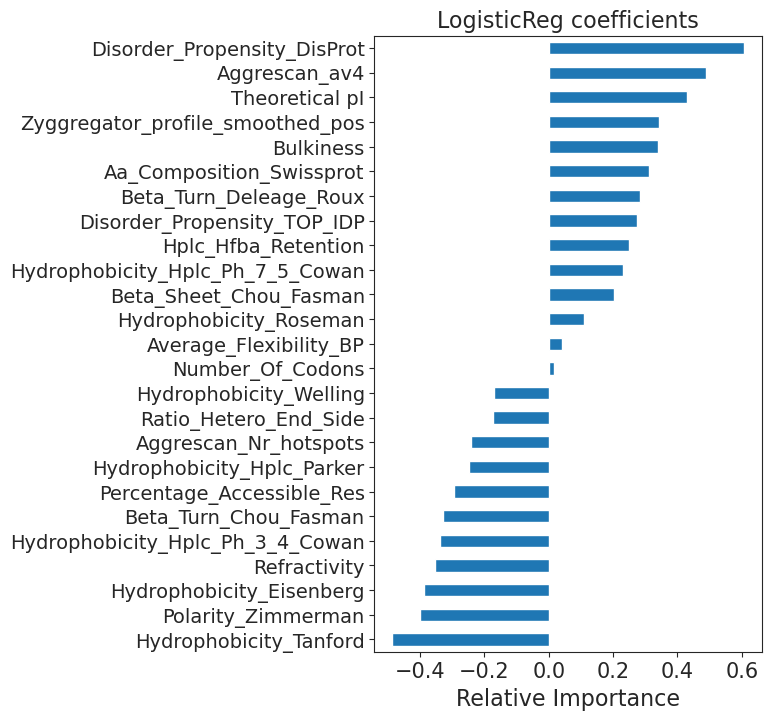

<Figure size 500x800 with 0 Axes>

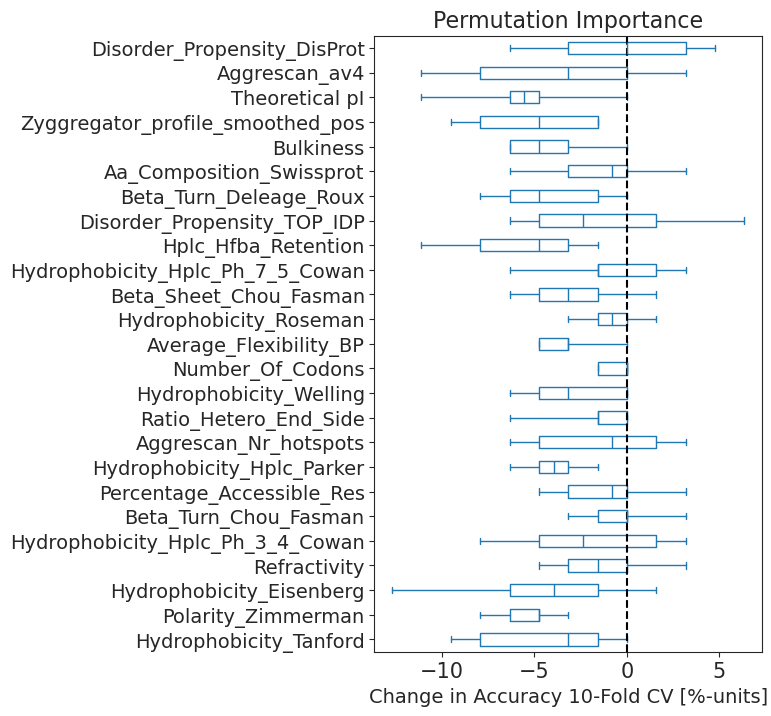

In [9]:
#%% Distribution of probability (incl. mildly non-specific)

def Distribution_10Fold_CV(Ab_type,feat_selected, model='LogisticReg', feat_list_name='All_descriptors'):

    # ML algorithms:
    seed=42
    classifier_dict={"LogisticReg": LogisticRegression(random_state=seed, max_iter=500),
                     "KNeighbors": KNeighborsClassifier(n_neighbors=3),
                     "Linear SVM": SVC(kernel="linear", C=0.025, random_state=seed,probability=True), # Uses Linear kernel.
                     "RBF SVM" : SVC(gamma=2, C=1, random_state=seed), # Uses Radial Basis Function kernel by default.
                     "Decision Tree" : DecisionTreeClassifier(max_depth=5, random_state=seed),
                     "GradientBootsting": GradientBoostingClassifier(random_state=seed),
                     "AdaBoost": AdaBoostClassifier(random_state=seed),
                     "RandomForest": RandomForestClassifier(random_state=seed),
                     "Gaussian_RBF": GaussianProcessClassifier(kernel=RBF(), random_state=seed, max_iter_predict=5000),
                     "Naive Bayes": GaussianNB(),
                     "QDA": QuadraticDiscriminantAnalysis(),
                     "XGBoostReg": xgb.XGBRegressor(objective="reg:linear", random_state=seed),
                     "XGBoost": xgb.XGBClassifier(objective="binary:logistic", random_state=seed),
                     }
    
    feature_importance = pd.DataFrame()
    feature_importance_abs = pd.DataFrame()
    importances_test = pd.DataFrame()
    importances_train = pd.DataFrame()
    feature_importance_list, feature_importance_abs_list, importances_test_list, importances_train_list = [],[],[],[]
    for i, Ab_type in enumerate([Ab_type]):

        
        # Data:
        X=dict_desc_Boughter[Ab_type]
        y=dict_desc_Boughter[Ab_type]
        ksplit = 10
        
        kf = KFold(n_splits=ksplit, shuffle=True, random_state = 42)
        
        df_results = {'model': [],
                      'feat': [],
                      'fold': [],
                      'accuracy 10-Fold CV': [],
                      'y_pred': [],
                      'prob class 0': [],
                      'prob class 1': [],
                      'react': [],
                      'class': [],
                      'test index': [],
                      }
        
        print(model, ': ', Ab_type)
        
        fold = 0    
        for train, test in kf.split(X, y):
        
            #print(f"Fold #{fold}")
                
            # Split into train and test:
            X_train = X.iloc[train]
            X_test0 = X.iloc[test]
            y_train = y.iloc[train]
            y_test = y.iloc[test]
         
            # Select two classes:
            y_train = X_train[(X_train['react']==0) | (X_train['react']>=4)]
            X_train = X_train[(X_train['react']==0) | (X_train['react']>=4)]
            X_train = np.array([np.array(X_train[feat_selected])[i,:] for i in range(len(X_train[feat_selected]))])
            
            y_test = X_test0[(X_test0['react']==0) | (X_test0['react']>=4)]
            X_test = X_test0[(X_test0['react']==0) | (X_test0['react']>=4)]
            X_test = np.array([np.array(X_test[feat_selected])[i,:] for i in range(len(X_test[feat_selected]))])
            
            # Normalize X:
            scaler = StandardScaler().fit(X_train)
            X_train = scaler.transform(X_train)
            scaler = StandardScaler().fit(X_test)
            X_test = scaler.transform(X_test)
        
            # Classify:
            clf=classifier_dict[model]
            clf.fit(X_train, y_train['class'].values)
            score_OneSplit = clf.score(X_test, y_test['class'].values)
            
            # Feature importance (compute importances):
            from sklearn.inspection import permutation_importance
            permut_train = permutation_importance(clf, X_train, list(y_train['class']),n_repeats=10, random_state=42)
            permut_test = permutation_importance(clf, X_test, list(y_test['class']),n_repeats=10, random_state=42)
    
            if model == 'LogisticReg':
                
                coefficients = clf.coef_[0]
    
                for j, feat in enumerate(feat_selected):
                    feature_importance_abs[feat] =  [list(np.abs(coefficients))[j]] 
                    feature_importance[feat] =  [list(coefficients)[j]]
                    importances_test[feat] = list(permut_test.importances)[j]
                    importances_train[feat] = list(permut_train.importances)[j]
        
            # --- For making of plot with mildly-polyreactive Abs,
            X_test_comb = X_test0
        
            y_test = X_test_comb
            X_test = np.array([np.array(X_test_comb[feat_selected])[i,:] for i in range(len(X_test_comb[feat_selected]))])
            
            # Normalize X:
            scaler = StandardScaler().fit(X_test)
            X_test = scaler.transform(X_test)
     
            if Ab_type == 'H-CDRs' or Ab_type == 'L-CDRs' or Ab_type=='HL-CDRs' or Ab_type=='VH_VL':
                feat_name = 'Baseline_'+ f"{Ab_type}" + '_joined'
            else:
                feat_name = 'Baseline_' + f"{Ab_type}"
            
            # Append results from 10-fold CV (two classes only):
            df_results["model"].append(model)
            df_results["feat"].append(feat_name)
            df_results["fold"].append(fold)
            df_results['accuracy 10-Fold CV'].append(score_OneSplit)
            
            # The rest are based on test set from 10-fold CV with mildly non-specific Ab's included:
            df_results['y_pred'].append(clf.predict(X_test))
            df_results['prob class 0'].append(list(clf.predict_proba(X_test)[:,0]))
            df_results['prob class 1'].append(list(clf.predict_proba(X_test)[:,1]))
            df_results["react"].append(list(y_test['react'].values))
            df_results["class"].append(list(y_test['class'].values))
            df_results['test index'].append(list(test))
            
            feature_importance_list.append(feature_importance)
            feature_importance_abs_list.append(feature_importance_abs)
            importances_test_list.append(importances_test)
            importances_train_list.append(importances_train)
    
            fold += 1
                    
        df_results = pd.DataFrame(df_results)
    
        # --- Re-assemble into one df:
        model_list, fold_list, accuracy_list, y_pred_list, prob_class1_list, react_list, class_list, test_index_list = [],[],[],[],[],[],[],[]
        for k in list(range(0,ksplit)):
            # Select data:
            df_temp = df_results[df_results['fold']==k]
            
            
            # Here, we append one 'value' per test:
            model_list.append(list(df_temp['model'])[0])
            fold_list.append(list(df_temp['fold'])[0])
            accuracy_list.append(list(df_temp['accuracy 10-Fold CV'])[0])
            y_pred_list.append(list(df_temp['y_pred'])[0])
            
            # Here, we append a list of all data points used in test set:
            prob_class1_list.append(list(df_temp['prob class 1'])[0])
            react_list.append(list(df_temp['react'])[0])
            class_list.append(list(df_temp['class'])[0])
            test_index_list.append(list(df_temp['test index'])[0])
            
        # Plot feature importance:
        feature_importance_abs = pd.concat(feature_importance_abs_list)
        feature_importance = pd.concat(feature_importance_list)
        importances_test = pd.concat(importances_test_list)
        importances_train = pd.concat(importances_train_list)
        
        feature_importance_abs.reset_index(drop=True, inplace=True)
        feature_importance.reset_index(drop=True, inplace=True)
        importances_test.reset_index(drop=True, inplace=True)
        importances_train.reset_index(drop=True, inplace=True)
        
        
        feature_importance_mean = feature_importance.mean() #feature_importance_abs
        feature_importance_mean = feature_importance_mean.sort_values(ascending=True)
        
        # --- Save to df:
        df_summary = pd.DataFrame()
        df_summary['Feature'] = feature_importance.mean().index
        df_summary['LogisticReg coeff. mean'] = feature_importance.mean().values
        df_summary['LogisticReg abs(coeff.) mean'] = feature_importance_abs.mean()[feature_importance.mean().index].values
        df_summary['LogisticReg permutation test'] = importances_test.mean()[feature_importance.mean().index].values
        #df_summary.to_excel('./Figures_publication/10-fold CV/Descriptors/Model_LogisticReg_'+str(Ab_type)+'_all_descriptors_summary.xlsx')
        
        importances_test = importances_test[feature_importance_mean.index] 
        
        plt.figure(2, figsize=(5,8))
        sns.set_style("white")
        sns.set_style('ticks') 
        feature_importance_mean.plot.barh(color='tab:blue', figsize=(5,8))
        plt.title("LogisticReg coefficients",fontsize=16)
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=14)
        plt.xlabel('Relative Importance', fontsize=16)
        plt.ylim(-0.50,len(feat_selected)-0.5)
        #plt.legend(loc='lower right')
        plt.savefig('./Figures/Fig2A_Subplot_feat_importance_coeff_'+str(ksplit)+'Fold_CV_'+str(model)+'_'+str(Ab_type)+'_'+str(feat_list_name)+'_v2.pdf',dpi=300, bbox_inches='tight')
        
        plt.figure(3, figsize=(5,8))
        sns.set_style("white")
        sns.set_style('ticks') 
        ax=(importances_test*-100).plot.box(color='tab:blue',vert=False, whis=10, figsize=(5,8))
        ax.xaxis.set_major_locator(plt.MaxNLocator(5))
        plt.title("Permutation Importance",fontsize=16)
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=14)
        plt.axvline(x=0, color="k", linestyle="--")
        plt.xlabel("Change in Accuracy 10-Fold CV [%-units]", fontsize=14)                   
        plt.savefig('./Figures/Fig2A_Subplot_feat_importance_permut_test_'+str(ksplit)+'Fold_CV_'+str(model)+'_'+str(Ab_type)+'_'+str(feat_list_name)+'_v2.pdf',dpi=300, bbox_inches='tight')
        
    return feature_importance_mean 

# --- All descriptors:
Ab_type = 'VH' 
feat_selected = desc_dict['desc_selected'] 
feat_selected_order = Distribution_10Fold_CV(Ab_type,feat_selected, feat_list_name='Top 25 descriptors')


### Leave-one-feature-out:

/tmp/ipykernel_73260/1131653836.py:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.barplot(data=cls_summary1[cls_summary1['Leave out feature']!='None'], #boxplot
/tmp/ipykernel_73260/1131653836.py:81: UserWarning: 
The palette list has fewer values (1) than needed (25) and will cycle, which may produce an uninterpretable plot.
  ax=sns.barplot(data=cls_summary1[cls_summary1['Leave out feature']!='None'], #boxplot


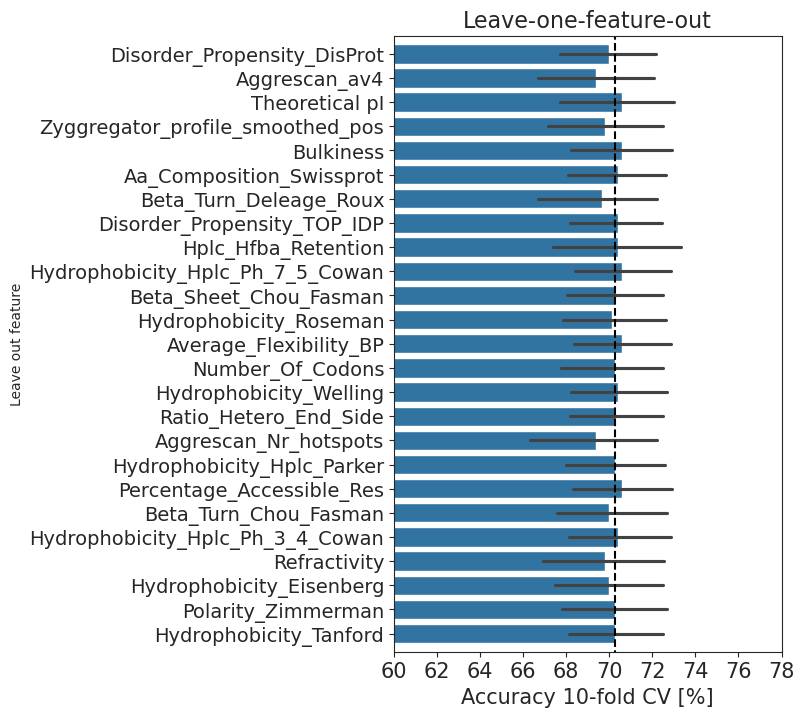

In [11]:
# Top 25 descriptors:
feature_selection = desc_dict['desc_selected']

Ab_type_list = ['VH']

# --- k-fold CV:
cls_summary_list = []
seed=42
for k_fold in [10]: 
    
    cls_summary1 = pd.DataFrame()
    cls_summary2 = pd.DataFrame()
    
    for Ab_type in Ab_type_list:
        
        if type(Ab_type) == str:
            # Data:
            sub_data_2classes = dict_desc_Boughter_2classes[Ab_type]
            
            # Leave one feature out:
            for feat in sum([['None'],feature_selection],[]):
                schrod_desc_sub = feature_selection.copy()
                if feat=='None':
                    pass                    
                else:
                    schrod_desc_sub = [f for f in schrod_desc_sub if f!=feat]
                
                
                X=np.array([np.array(sub_data_2classes[schrod_desc_sub])[i,:] for i in range(len(sub_data_2classes[schrod_desc_sub]))])
                y=sub_data_2classes['class'].values
            
                feat_name = 'Baseline_' + f"{Ab_type}"


                # Normalize X:
                scaler = StandardScaler().fit(X)
                X = scaler.transform(X)


                # ML algorithms:
                classifier_dict={"LogisticReg": LogisticRegression(random_state=seed, max_iter=500)}        

                # Train and test with kFold CV:
                cls_stats1  = classification(X,
                                             y,
                                             classifier_dict,
                                             n_folds=k_fold,
                                             random_state=seed,
                                             verbose=False,
                                             )


                cls_stats1 = pd.DataFrame(cls_stats1)
                cls_stats1["feat"] = feat_name
                cls_stats1["Leave out feature"] = feat
                cls_summary1 = pd.concat([cls_summary1, cls_stats1], ignore_index=True) 
                cls_summary1 = cls_summary1[["feat","Leave out feature"] + [col for col in cls_summary1.columns if (col not in ["feat","Leave out feature"]) ]]
                
                cls_summary_list.append(cls_summary1)

        # Save output to excel:
        #cls_summary1.to_excel('./kFoldCV/Baseline_models_two_classes_'+str(k_fold)+'CV'+'_results_all_descriptors.xlsx')  

# 10-fold CV accuracy:
Data_10CV_mean = cls_summary1.groupby(['feat','Leave out feature','model']).mean()
Data_10CV_std = cls_summary1.groupby(['feat','Leave out feature','model']).std()
Data_10CV_mean.rename(columns={'accuracy':'accuracy mean', 'sensitivity': 'sensitivity mean', 'specificity': 'specificity mean'}, inplace=True)
Data_10CV_std.rename(columns={'accuracy':'accuracy std', 'sensitivity': 'sensitivity std', 'specificity': 'specificity std'}, inplace=True)
Data_10CV_mean = Data_10CV_mean.sort_values(by='accuracy mean',ascending=True)

# Add decrease in accuracy:
mean_all_features = cls_summary1[cls_summary1['Leave out feature']=='None']['accuracy'].mean()
cls_summary1['Decrease in accuracy [%]'] = [-100*(i-mean_all_features) for i in list(cls_summary1['accuracy'])]
cls_summary1['accuracy [%]'] = [100*i for i in list(cls_summary1['accuracy'])]
cls_summary1['model name'] = ['VH-based LogisticReg' for i in list(cls_summary1['accuracy'])]
#cls_summary1.to_excel('./Data/kFoldCV/Leave-one-desc-out_Baseline_model_two_classes_'+str(k_fold)+'CV'+'_LogisticReg_VH_all_descriptors.xlsx')  

# Plot:
plt.figure(1, figsize=(5,8))

ax=sns.barplot(data=cls_summary1[cls_summary1['Leave out feature']!='None'], #boxplot
            y='Leave out feature',
            x='accuracy [%]',#'Decrease in accuracy [%]',
            #hue='model name',
            order=list(feat_selected_order.index),
            orient='h',    
            palette=['tab:blue'],
            )

order=list(feat_selected_order.index)
#plt.vlines(0,-1,len(order), linestyle='--', color='black')
plt.vlines(mean_all_features*100,-1,len(order), linestyle='--', color='black')
plt.ylim(-0.75,len(order)-0.25)
plt.xlim(60,78)
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
plt.yticks(fontsize=14)
plt.xticks(fontsize=15)
plt.xlabel('Accuracy 10-fold CV [%]', fontsize=15)
plt.title('Leave-one-feature-out', fontsize=16)
plt.savefig('./Figures/Fig2A_Leave_one_feature_out_10Fold_CV_VH_LogisticReg_nonreduntant_descriptors.pdf',dpi=300, bbox_inches='tight')
plt.show()


### Single descriptor-based models:

In [12]:
# Top 25 descriptors:
feature_selection = desc_dict['desc_all']

Ab_type_list_norm = ['VH']

Ab_type_list = ['VH']

Ab_type = 'VH'


# --- Normalize all descriptors first:
# Normalize descriptors:
dict_Boughter_2classes_norm = {}
for Ab_type in Ab_type_list_norm:
    sub_data_2classes = dict_desc_Boughter_2classes[Ab_type]
    sub_data_2classes_norm = sub_data_2classes.copy()
    for desc in feature_selection:
        desc_i = np.array(sub_data_2classes_norm[desc]).reshape(-1, 1)
        scaler = StandardScaler().fit(desc_i) 
        sub_data_2classes_norm[desc+'_norm'] = list(scaler.transform(desc_i))
    
    dict_Boughter_2classes_norm[Ab_type] = sub_data_2classes_norm


# --- k-fold CV:
seed=42
for k_fold in [3, 5, 10]: 
    
    cls_summary1 = pd.DataFrame()
    
    for Ab_type in Ab_type_list:
        
        for desc in feature_selection:
        
            if type(Ab_type) == str:
                # Data:
                sub_data_2classes = dict_Boughter_2classes_norm[Ab_type]

                X=np.array([np.array(sub_data_2classes[desc+'_norm'])[i] for i in range(len(sub_data_2classes[desc+'_norm']))])
                y=sub_data_2classes['class'].values

                if Ab_type == 'H-CDRs' or Ab_type == 'L-CDRs' or Ab_type=='HL-CDRs' or Ab_type=='VH_VL':
                        feat_name = 'Baseline_'+ f"{Ab_type}" + '_joined'
                else:
                        feat_name = 'Baseline_' + f"{Ab_type}"

            else:
                feat_name = 'Baseline_'+'_'.join(Ab_type)+'_concat'
                # Data:
                sub_data_2classes_list = []
                for Ab_domain in Ab_type:
                    sub_data_2classes_list.append(dict_Boughter_2classes_norm[Ab_domain])

                X = np.array([np.array([sub_data_2classes_list[j][desc+'_norm'].iloc[i][0] for j in range(len(sub_data_2classes_list))]) for i in range(len(sub_data_2classes_list[0]['Dataset']))])
                y=sub_data_2classes_list[0]['class'].values # Just choose one of them (VH, in this case) as class is the same in both VH and VL dataframes.


            # ML algorithms:
            classifier_dict={"LogisticReg": LogisticRegression(random_state=seed, max_iter=500),
                             "RandomForest": RandomForestClassifier(random_state=seed),
                             }        

            # Train and test with kFold CV:
            cls_stats1  = classification(X,
                                         y,
                                         classifier_dict,
                                         n_folds=k_fold,
                                         random_state=seed,
                                         verbose=False,
                                         )


            cls_stats1 = pd.DataFrame(cls_stats1)
            cls_stats1["feat"] = feat_name
            cls_stats1["desc"] = desc+'_norm'
            cls_summary1 = pd.concat([cls_summary1, cls_stats1], ignore_index=True) 
            cls_summary1 = cls_summary1[["feat"] + [col for col in cls_summary1.columns if col != "feat"]]


    # Save output to excel:
    cls_summary1.to_excel('./Data/kFoldCV/Descriptor_specific_VH_models_'+str(k_fold)+'CV'+'_results.xlsx')  

cls_summary1


KeyboardInterrupt: 

In [13]:
# --- Re-load all results:
df_3CV_desc_models = pd.read_excel('./Data/kFoldCV/Descriptor_specific_VH_models_3CV_results.xlsx')
df_5CV_desc_models = pd.read_excel('./Data/kFoldCV/Descriptor_specific_VH_models_5CV_results.xlsx')
df_10CV_desc_models = pd.read_excel('./Data/kFoldCV/Descriptor_specific_VH_models_10CV_results.xlsx')

df_3CV_desc_models['desc'] = [i.split('_norm')[0] for i in list(df_3CV_desc_models['desc'])]
df_5CV_desc_models['desc'] = [i.split('_norm')[0] for i in list(df_5CV_desc_models['desc'])]
df_10CV_desc_models['desc'] = [i.split('_norm')[0] for i in list(df_10CV_desc_models['desc'])]


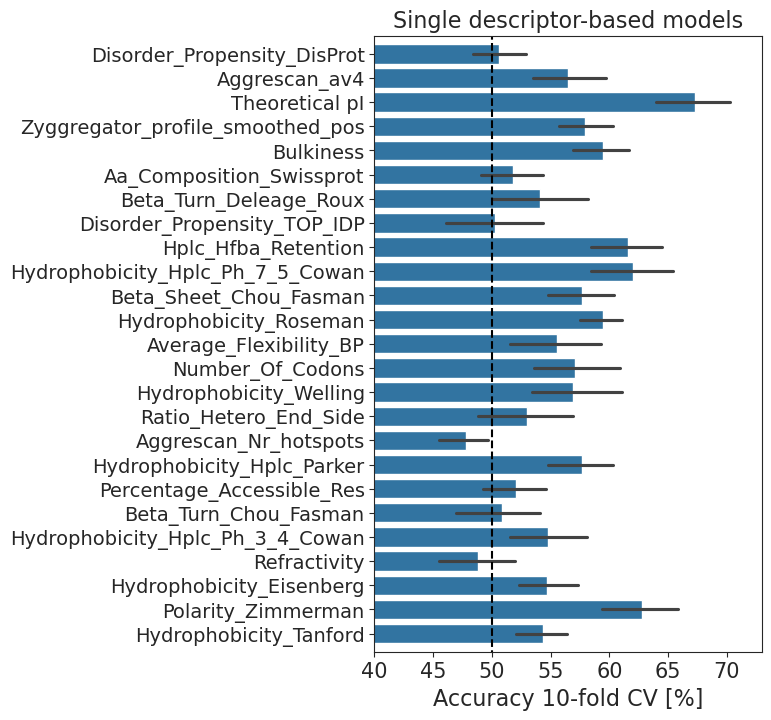

In [14]:
# --- PLotting of preformance of descriptor-based models:
plt.figure(1, figsize=(5,8))
feature_selection = desc_dict['desc_selected'] 
df_plot_10CV = df_10CV_desc_models[df_10CV_desc_models['desc'].isin(feature_selection)]
df_plot_10CV = df_plot_10CV[df_plot_10CV['model']=='LogisticReg']

df_plot_10CV ['accuracy [%]'] = [i*100 for i in list(df_plot_10CV ['accuracy'])]
sns.barplot(data=df_plot_10CV,
            y='desc',
            x='accuracy [%]',
            order=list(feat_selected_order.index),
            orient='h',
            color='tab:blue',
            )

plt.vlines(50, -1, len(order)+1, linestyle='--', color='black')
plt.ylim(-0.75, len(order)-0.25)
plt.xlim(40,73)
plt.yticks(fontsize=14)
plt.xticks(fontsize=15)
plt.title('Single descriptor-based models',fontsize=16)
plt.ylabel('')
plt.xlabel('Accuracy 10-fold CV [%]', fontsize=16)
plt.savefig('./Figures/Fig2A_single_descriptor_models_10Fold_CV_VH_LogisticReg.pdf',dpi=300, bbox_inches='tight')

plt.show()
